# Cheap Chicago Living

## Final Project for Applied Data Science Capstone Course
Samantha Goodman<br>
3/6/2020

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Data Collection: City of Chicago](#chicago_data)
* [Data Collection: Scraping Craigslist](#cl_data)
* [Data Collection: Foursquare](#foursquare_data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this notebook, we will find an ideal train stop for a person to look for an apartment in Chicago. A unique aspect of this project is that instead of a neighborhood, it recommends a stop on the 'el' or metro line. This project can be adapted for many situations, but our test case scenario is a young student at the local university (UIC) with the following needs:
<ul><li>A cheap 1 bedroom or studio apartment near the train (within 600m)
    <li>Near the Blue line (the only train line that stops at UIC)
    <li>Many bars also within 600m

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:

* number of cheap apartments currently available for rent
* average rental price for apartments nearby
* number of bars nearby

We decided to use each train stop as a mini-neighborhood, and looked at apartments and bars within 600 meters of 
each stop.

Following data sources will be needed to extract/generate the required information:

* Location data of each train stop
* The zip code of each train stop (for searching for apartments)
* The location and price of apartments within 600m of each train stop
* The number of bars within 600m of each train stop

In [1]:
# Import the necessary libraries
from geopy.geocoders import Nominatim
import folium
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup # For scraping websites
# requests for fetching html of website
from requests import get
import requests

In [2]:
# Create a geolocator using Nominatim of OpenStreetMap
geolocator = Nominatim(timeout=10, user_agent = "sje.Capstone-Project")

## Data Collection: City of Chicago<a name="chicago_data"></a>
I chose to base my data collection and analysis around the CTA metro (known as 'the el'), and found data about the metro stops on the City of Chicago Data Portal.

In [3]:
# Read the CSV using the City of Chicago data
stations = pd.read_csv("https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD")
stations.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


Since my test case (a young person looking for a cheap apartment with lots of bars near the Blue Line) I selected only blue line stations to work with

In [4]:
blue_line = stations[stations['BLUE'] == True ]
blue_line = pd.DataFrame(blue_line)
blue_line.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
33,30002,W,Austin (Forest Pk-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
34,30001,E,Austin (O'Hare-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
37,30013,S,Belmont (O'Hare Branch) (Forest Pk-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
38,30012,N,Belmont (O'Hare Branch) (O'Hare-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
61,30188,W,Cicero (Forest Pk-bound),Cicero,Cicero (Blue Line),40970,False,False,True,False,False,False,False,False,False,False,"(41.871574, -87.745154)"


Each stop is listed twice, so I remove duplicates

In [5]:
blue_line.drop_duplicates(subset ="Location", inplace = True)
blue_line.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
33,30002,W,Austin (Forest Pk-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
37,30013,S,Belmont (O'Hare Branch) (Forest Pk-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
61,30188,W,Cicero (Forest Pk-bound),Cicero,Cicero (Blue Line),40970,False,False,True,False,False,False,False,False,False,False,"(41.871574, -87.745154)"
67,30374,S,Clark/Lake (Forest Pk-bound),Clark/Lake,"Clark/Lake (Blue, Brown, Green, Orange, Purple...",40380,True,False,True,False,False,False,False,False,False,False,"(41.885737, -87.630886)"
69,30085,W,Clinton (Forest Pk-bound),Clinton,Clinton (Blue Line),40430,False,False,True,False,False,False,False,False,False,False,"(41.875539, -87.640984)"


In [6]:
# Spliting location data into two columns to extract the longitude and latitude
blue_line['Latitude'], blue_line['Longitude'] = blue_line['Location'].str.split(' ', 1).str
# Drop all the extra columns
blue_line.drop(['DIRECTION_ID', 'STATION_NAME', 'MAP_ID', 'STOP_NAME', 'ADA', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y', 'Pnk', 'O'], axis = 1, inplace=True)
# Rename some columns
blue_line['STATION_DESCRIPTIVE_NAME'] = blue_line['STATION_DESCRIPTIVE_NAME'].str.replace('(Blue Line)', '', regex=False)
blue_line.rename(columns={'STATION_DESCRIPTIVE_NAME': 'Station'}, inplace=True)
blue_line.set_index("STOP_ID", inplace=True)
# Rename Clark/Lake to shorter name
blue_line.at[30374,'Station'] = 'Clark/Lake'
blue_line.head()

<ipython-input-6-40e07f682c72>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  blue_line['Latitude'], blue_line['Longitude'] = blue_line['Location'].str.split(' ', 1).str


,Station,Location,Latitude,Longitude
STOP_ID,,,,
30002,Austin,"(41.870851, -87.776812)","(41.870851,",-87.776812)
30013,Belmont,"(41.938132, -87.712359)","(41.938132,",-87.712359)
30188,Cicero,"(41.871574, -87.745154)","(41.871574,",-87.745154)
30374,Clark/Lake,"(41.885737, -87.630886)","(41.885737,",-87.630886)
30085,Clinton,"(41.875539, -87.640984)","(41.875539,",-87.640984)


Some station names contain other station names, which will make searching later very difficult. I rename them with abbreviations instead.

In [7]:
blue_line['Station'] = blue_line["Station"].str.replace('(Blue Line - O\'Hare Branch)', '(OH Branch)', regex=False)
blue_line['Station'] = blue_line["Station"].str.replace('(Blue Line - Forest Park Branch)', '(FB Branch)', regex=False)

In [8]:
blue_line.tail()

,Station,Location,Latitude,Longitude
STOP_ID,,,,
30111,California,"(41.921939, -87.69689)","(41.921939,",-87.69689)
30271,Chicago,"(41.896075, -87.655214)","(41.896075,",-87.655214)
30130,Western (OH Branch),"(41.916157, -87.687364)","(41.916157,",-87.687364)
30042,Western (FB Branch),"(41.875478, -87.688436)","(41.875478,",-87.688436)
30240,Addison,"(41.94738, -87.71906)","(41.94738,",-87.71906)


In [9]:
# Extract location data and save as floats
blue_line['Longitude'] = blue_line["Longitude"].str.replace(')', '', regex=False)
blue_line['Latitude'] = blue_line["Latitude"].str.replace('(', '', regex=False)
blue_line['Latitude'] = blue_line["Latitude"].str.replace(',', '', regex=False)
blue_line[["Longitude"]] = blue_line[["Longitude"]].astype("float")
blue_line[["Latitude"]] = blue_line[["Latitude"]].astype("float")
blue_line.head()

,Station,Location,Latitude,Longitude
STOP_ID,,,,
30002,Austin,"(41.870851, -87.776812)",41.870851,-87.776812
30013,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359
30188,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154
30374,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886
30085,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984


Add zipcodes to dataframe for use later when scraping Craigslist

In [10]:
# This function strips the parenthesis from the 'Location' column and returns a zipcode string
def getzip (location_info):
    
    zipcode = geolocator.geocode(location_info[1:-1], addressdetails=True).raw['address']['postcode']
    return zipcode[0:5]

In [11]:
blue_line['Zipcode'] = blue_line['Location'].apply(getzip)
blue_line.head()

,Station,Location,Latitude,Longitude,Zipcode
STOP_ID,,,,,
30002,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,60130
30013,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359,60659
30188,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154,60644
30374,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886,60696
30085,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984,60606


In [12]:
# Let's get the basic location data for Chicago, just to get started
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="sje_capstone-project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


## Here is a map of the Chicago Blue Line stops, with a circle of 600m around each stop. This represents the area all further searching and analysis will take place

In [13]:
# create map of Chciago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)
    folium.Circle([lat, lng], radius=600, color='red', fill=False).add_to(map_chicago)
  
    
map_chicago


## Data Collection: Scraping Craigslist<a name="cl_data"></a>

In [14]:
from time import sleep
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
from geopy import distance

In [15]:
# Create a list of zipcodes to scrape
blue_line.reset_index(drop=True, inplace=True)
blue_line.head()

,Station,Location,Latitude,Longitude,Zipcode
0,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,60130
1,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359,60659
2,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154,60644
3,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886,60696
4,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984,60606


In [16]:
ziplist = blue_line['Zipcode']
ziplist = list(dict.fromkeys(ziplist))
print(ziplist)
print(str(len(ziplist)) + " unique zipcodes")

['60130', '60659', '60644', '60696', '60606', '60631', '60647', '60642', '60661', '60656', '60607', '60641', '60604', '60630', '60605', '60603', '60688', '60018', '60602', '60625', '60618']
21 unique zipcodes


### Craigslist scraping involved creating long URLs to specify your search parameters

In [17]:
# This function concats all of the search paramters into a long url
def get_cl_url (zipcode, distance, page, min_bed, max_bed):
    cl_url =("https://chicago.craigslist.org/search/apa?"
                   + "&search_distance="
                   + distance
                   + "&postal="
                   + zipcode
                   + "&min_bedrooms="
                   + min_bed
                   + "&max_bedrooms="
                   + max_bed
                   + "&s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&availabilityMode=0")
    return cl_url

Because the listing page doesn't have location data (lat and long), 
I wrote a function to visit that link, and pull the data for that listing.

In [18]:
# This function pulls the location data by scraping the page on a URL
def get_loc_from_listing (url):
  #get the latitude and longitude from a URL listing
  listingHtml = get(url)
  listSoup = BeautifulSoup(listingHtml.text, 'html.parser')
  location = listSoup.find_all(class_= 'viewposting')
  loc = []
  if location[0] is None:
      loc.append('null')
      loc.append('null')

  else:
      loc.append(float(location[0]['data-latitude']))
      loc.append(float(location[0]['data-longitude']))
  return loc

Here is where the data is scraped from Craigslist. I found that if the entire city of Chicago was scraped, many apartment listings were missing from the data. A workaround is to use each zipcode in the blue_line dataset as a search parameter, and then just remove duplicates later.

In [ ]:
# Create empty arrays for storing data
post_title_texts = []
post_hoods = []
post_links = []
post_prices = []
longitudes = []
latitudes = []
post_zipcodes = []

for zipcode in ziplist:
    
    #get the first page of the chicago housing listings in this zipcode
    response = get(get_cl_url(zipcode,'2','0','0','1')) # 0 or 1 bedrooms 2 mi from zipcode

    html_soup = BeautifulSoup(response.text, 'html.parser')

    #get the macro-container for the housing posts
    posts = html_soup.find_all('li', class_= 'result-row')


    #find the total number of posts to find the limit of the pagination
    results_num = html_soup.find('div', class_= 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)

    iterations = 0


    for page in pages:

        #get request
        response = get(get_cl_url(zipcode,'2', page,'0','1')) #Searches for one bedrooms or studios

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = html_soup.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            if post.find('span', class_ = 'result-hood') is not None:

                #neighborhoods
                post_hood = post.find('span', class_= 'result-hood').text
                post_hoods.append(post_hood)

                #title text
                post_title = post.find('a', class_='result-title hdrlnk')
                post_title_text = post_title.text
                post_title_texts.append(post_title_text)

                #post link
                post_link = post_title['href']
                post_links.append(post_link)

                # Location Data
                bothloc = get_loc_from_listing(post_link)
                latitudes.append(bothloc[0])
                longitudes.append(bothloc[1])

                #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
                post_price = post.a.text.strip().replace("$", "")
                post_prices.append(post_price)
                
                # Records the zipcode it was searched by
                post_zipcodes.append(zipcode)


        iterations += 1
        print("Page " + str(iterations) + " of zipcode "+ zipcode + " scraped successfully!")


print("\n")

print("Scrape complete!")

In [ ]:
# Saves the scraped data to a dataframe
chi_apts = pd.DataFrame({'neighborhood': post_hoods,
                       'post title': post_title_texts,
                        'URL': post_links,
                       'price': post_prices,
                        'longitude': longitudes,
                        'latitude': latitudes})
chi_apts.head(10)

Because scaping the data takes so long, I chose to save it to a .csv file for future use. 

In [ ]:
#write dataframe to file so I don't have to scrape again
chi_apts.to_csv("scraped_data.csv")  

In [19]:
# Use this if the data has already been scraped and saved
chi_apts = pd.read_csv("scraped_data.csv", index_col=0)
chi_apts.head()

,neighborhood,post title,URL,price,longitude,latitude
0,(Forest Park),"BRIGHT 1 BED, SS Appliances with Balcony - MET...",https://chicago.craigslist.org/nch/apa/d/fores...,995.0,-87.8106,41.8744
1,(Forest Park),Studio ($690) and 1 Bedroom ($810/$850) Apartm...,https://chicago.craigslist.org/nwc/apa/d/studi...,NaN,-87.8106,41.8744
2,(FOREST PARK),GIANT BALCONY & HEATED GARAGE 1 BDRM APT.,https://chicago.craigslist.org/wcl/apa/d/giant...,1100.0,-87.8106,41.8744
3,(Forest Park),SEMI-MODERN ONE BEDROOMS FROM $1005-1015 - 227,https://chicago.craigslist.org/wcl/apa/d/fores...,1005.0,-87.8106,41.8744
4,(Forest Park),"FOREST PARK / OAK PARK 1 Bedroom, Balcony, 601...",https://chicago.craigslist.org/nch/apa/d/fores...,985.0,-87.8106,41.8744


In [ ]:
chi_apts.shape

The total scraped data contains 8813 rows. However, many of the apartment listings are duplicates, so we will do extsive cleaning to get a more accurate picture of what is available.

### Craigslist data cleaning section

In [20]:
# Drops any apartments missing price data
chi_apts.drop( chi_apts[ chi_apts['price'] == '' ].index , inplace=True)
chi_apts.dropna(subset=['price'], inplace=True)
# Convert prices to int
chi_apts['price'] = chi_apts['price'].apply(lambda x: int(x))
# Drop any apartments less than 300 (often spam)
chi_apts.drop( chi_apts[ chi_apts['price'] <500 ].index , inplace=True)
# Drop any apartments more than 5000 (often spam or mis-listings)
chi_apts.drop( chi_apts[ chi_apts['price'] >5000 ].index , inplace=True)
# Remove duplicates with same URL - these are relistings
chi_apts = chi_apts.drop_duplicates(subset='URL')
# Remove duplicates with same post titles and price - these are most likely relistings
chi_apts = chi_apts.drop_duplicates(subset=['post title', 'price'])
chi_apts.sort_values(['price'], inplace=True)

chi_apts.reset_index(drop=True, inplace=True)


/Users/samanthagoodman/.local/share/virtualenvs/Coursera_Capstone-w3K9iyP0/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [21]:
chi_apts.shape

(808, 6)

Wow! From 8813 to 808 listings. That is a lot of duplicate craigslist listings.

Next , we need to know which train stations each apartment listing is near. Below is a function that
calculates the distance to each train stop, and if it is less than 600m, records the name of the station in the
'Nearby Stations' column.

In [22]:
# Add nearby stations column for each apartment listing
chi_apts['Nearby Stations'] = 'None'

# For each stop in the blue line listing
for index, row in blue_line.iterrows(): 
    # Stores this stops location data
    station_lat = row['Latitude']
    station_long = row['Longitude']
    station_name = row['Station']
    # For each listing in the apartments datframe
    for index, apt_row in chi_apts.iterrows():
        # If it is less than 600 meters from the stop, add the stop name to the column
        if distance.distance((station_lat, station_long), (apt_row.latitude, apt_row.longitude)).m < 600:
            if chi_apts.at[index,'Nearby Stations'] == 'None':
                chi_apts.at[index,'Nearby Stations'] = station_name
            else:
                chi_apts.at[index,'Nearby Stations'] += (", " + station_name)

In [23]:
# Saves the nearby apartments to a new dataframe
nearby_apts = chi_apts.drop( chi_apts[ chi_apts['Nearby Stations'] == 'None' ].index)
nearby_apts.head()

,neighborhood,post title,URL,price,longitude,latitude,Nearby Stations
8,(Harvard and Austin),Oak Park Studio $750,https://chicago.craigslist.org/wcl/apa/d/oak-p...,750,-87.774157,41.869131,Austin
9,(Elmhurst),CHEAP & CLEAN 1 BDRM GARDEN APT.,https://chicago.craigslist.org/wcl/apa/d/fores...,750,-87.810600,41.874400,"Forest Park , Harlem (FB Branch)"
10,(Chicago`),Studio Chicago/Oak Park Border $750,https://chicago.craigslist.org/wcl/apa/d/oak-p...,750,-87.774057,41.867231,Austin
12,(Chicago),Large Fresh!! 1BDR Lower Unit w/Carpet! New Li...,https://chicago.craigslist.org/chc/apa/d/chica...,765,-87.632100,41.882900,"Clark/Lake, Jackson , Monroe , Washington"
18,(Jefferson Park),1BR Garden Jefferson Park,https://chicago.craigslist.org/chc/apa/d/chica...,800,-87.760059,41.973231,Jefferson Park


As an easy way to rate each apartment by price, pd.cut is used to create three equal bins of price category: Low, Med, High. This is not based on the number of apartments in each bin, but just the overall price range. Also note, only nearby apartments are compared, not the entire dataset of scraped apartments.

In [24]:
# Rates the price of the apartment, based on three categories
nearby_apts['Rent'] = pd.cut(nearby_apts['price'], bins=3, labels=['low', 'med', 'high'])
nearby_apts['Rent'].value_counts()

med     204
low     115
high     16
Name: Rent, dtype: int64

### Here is a map with all nearby apartments added

In [25]:
# create map of Chicago using latitude and longitude values
map_chi = folium.Map(location=[latitude, longitude], zoom_start=15)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chi)
    folium.Circle([lat, lng], radius=600, color='red', fill=False).add_to(map_chi)

# add apartment markers to map
for lat, lng, price in zip(nearby_apts['latitude'], nearby_apts['longitude'], ('$' + nearby_apts['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_chi)  
    
map_chi

## Data Collection: Foursquare<a name="foursquare_data"></a>
### The next goal is get all bars withing 600m of a train stop, so we can compare train stops

In [26]:
# These are my personal ID and secret for the foursquare API
CLIENT_ID = 'V3B13NWETEWPBCDTZN0ZV0DWICYSVMSNIXJ5YVPFM4ILS51M' # my Foursquare ID
CLIENT_SECRET = '2JSJLEWXWFCVC1LEEGYK5TXYPTQMNRZDEFZ1EX0TVHXXWRBK' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V3B13NWETEWPBCDTZN0ZV0DWICYSVMSNIXJ5YVPFM4ILS51M
CLIENT_SECRET:2JSJLEWXWFCVC1LEEGYK5TXYPTQMNRZDEFZ1EX0TVHXXWRBK


In [27]:
# Defines a function that creates a foursquare URL to use the API
def get_foursquare_url (lat, long, radius, limit, section):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, radius, limit, section)
    return url

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
# Function that gets the bars within a given radius of a location
def get_area_bars (lat, long, radius):
    url = get_foursquare_url(lat, long, radius, 200, 'drinks')
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    # rename columns
    nearby_venues.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
    
    # See if it's a bar based on category name
    nearby_venues['isBar'] = nearby_venues['categories'].str.contains('Bar|Speakeasy|Lounge|Nightclub|Pub|Gastropub|Brewery')
    
    # Filters for venues that are bars
    bars = nearby_venues[ nearby_venues['isBar'] == True ]
    
    return bars

Lets test the code with the information for the Damen Blue Line Stop

In [30]:
damen_lat = float(blue_line.loc[blue_line['Station'] == 'Damen '].Latitude)
damen_long = float(blue_line.loc[blue_line['Station'] == 'Damen '].Longitude)
print(damen_lat)
print(damen_long)

41.909744
-87.677437


In [31]:
damen_bars = get_area_bars(damen_lat, damen_long, 600)
damen_bars.head()

,name,categories,latitude,longitude,isBar
2,The Violet Hour,Speakeasy,41.909048,-87.677631,True
3,The Robey Lounge,Lounge,41.910593,-87.678017,True
4,Tapster,Beer Bar,41.910395,-87.678516,True
5,Links Taproom,Bar,41.909894,-87.676488,True
6,SubT Lounge,Bar,41.910528,-87.677956,True


Looks good - a list of bars within 600m of the Damen train stop.

## Methodology<a name="methodology"></a>

In this project the results will be based on the train stop that has the highest number of cheap apartments, and the highest number of bars, all within 600m of the train stop. If two or more train stops have similar data, then the average rent can be compared, with the idea that average rent can be used to infer the average price of drinks in the area as well.

Once the data is organized, simple counts and averages are used to compare the train stops.

Because many train stops are within 600m of each other, some apartments and bars are counted multiple times. But because we are isolating each train stop and comparing the area immediately around it, this duplication doesn't affect our analysis.

## Analysis<a name="Analysis"></a>

First we create an empty dataframe to store the data on each train stop. We will then consilidate data from our various sources
(apartment listings and nearby bars)

In [32]:
# Builds empty dataframe for storing all data on each train stop (our goal!)
columns = ['Train Stop', 'Avg Rent', 'Num Apts', 'Cheap', 'Med', 'Luxury', 'Bars']
stop_data = pd.DataFrame(columns=columns)

# Stores the names of each stop in a row
stop_data['Train Stop'] = blue_line['Station']
stop_data['Longitude'] = blue_line['Longitude']
stop_data['Latitude'] = blue_line['Latitude']

stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,NaN,NaN,NaN,NaN,NaN,NaN,-87.776812,41.870851
1,Belmont,NaN,NaN,NaN,NaN,NaN,NaN,-87.712359,41.938132
2,Cicero,NaN,NaN,NaN,NaN,NaN,NaN,-87.745154,41.871574
3,Clark/Lake,NaN,NaN,NaN,NaN,NaN,NaN,-87.630886,41.885737
4,Clinton,NaN,NaN,NaN,NaN,NaN,NaN,-87.640984,41.875539


Now that we have an empty dataframe for all 33 stops of the Blue Line, we will fill it with data from the nearby_apts

In [33]:
# For each stop in stop_data
for index, row in stop_data.iterrows():
    # store the stop name as a string
    station_name = row['Train Stop']
    # Count the total number of apartments nearby
    stop_data.at[index, 'Num Apts'] = int(nearby_apts[nearby_apts['Nearby Stations'].str.contains(station_name)].count().price)
    # If there are apartments nearby, calculate the average rent
    if(stop_data.at[index, 'Num Apts'] !=0):
        stop_data.at[index, 'Avg Rent'] = int(nearby_apts[nearby_apts['Nearby Stations'].str.contains(station_name)].mean().price)
    else:
        stop_data.at[index, 'Avg Rent'] = None
    # Count the number of low, med, high rent apartments near this stop
    stop_data.at[index,'Cheap'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='low')].count().price
    stop_data.at[index,'Med'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='med')].count().price
    stop_data.at[index,'Luxury'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='high')].count().price

/Users/samanthagoodman/.local/share/virtualenvs/Coursera_Capstone-w3K9iyP0/lib/python3.8/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [34]:
stop_data.sort_values(['Avg Rent'], inplace=True)
stop_data.reset_index(drop=True, inplace=True)
# Drops all train stops that currently have no apartments listed nearby
stop_data = stop_data.drop( stop_data[ stop_data['Num Apts'] == 0 ].index)

stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,950,6,6,0,0,NaN,-87.776812,41.870851
1,Forest Park,1006,8,8,0,0,NaN,-87.817318,41.874257
2,Jefferson Park,1062,4,4,0,0,NaN,-87.760892,41.970634
3,Logan Square,1322,31,30,1,0,NaN,-87.708541,41.929728
4,Oak Park,1330,9,9,0,0,NaN,-87.791602,41.872108


Now that we have the apartment data for each stop stored in the dataframe, we add the number of bars for each
train stop.

In [35]:
# For each stop in stop_data
for index, row in stop_data.iterrows(): 
    # Stores this stops location data
    station_lat = row['Latitude']
    station_long = row['Longitude']
    station_name = row['Train Stop']
    sleep(randint(1,5)) # This prevents the API from disconnecting
    
    # Use get_area_bars method to get bars for this train stop
    nearby_bars = get_area_bars(station_lat, station_long, 600)
    num_bars = nearby_bars.count().isBar
    
    # Stores the number of bars counted into the dataframe vstop_data
    stop_data.at[index, 'Bars'] = num_bars

Sort the dataframe by number of cheap aparment, then average rent, then number of bars.

In [36]:
stop_data.sort_values(by=['Cheap','Avg Rent','Bars'], inplace=True, ascending=False)
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
3,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
10,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
4,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
16,Washington,2015,54,8,34,12,53,-87.629440,41.883164
1,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


In [37]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [38]:
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.3


In [39]:
# Reset index based on sorting
stop_data.reset_index(drop=True, inplace=True)
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
1,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
2,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
3,Washington,2015,54,8,34,12,53,-87.629440,41.883164
4,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


So now we have a completed data frame with our information gathered in one place. In order to visualize the difference between stops, we will look at the top 10 based on our sort (number of cheap apartments, average rent, number of bars)

In [40]:
# Selects the top 10 train stops to consider based on our sort
top_stops = stop_data.iloc[0:10]

In [41]:
top_stops = top_stops[['Train Stop', 'Cheap', 'Bars', 'Avg Rent']]
top_stops.rename(columns={'Cheap': 'Cheap Apts'}, inplace=True)

In [42]:
top_stops.set_index("Train Stop", inplace=True)
top_stops.head()

,Cheap Apts,Bars,Avg Rent
Train Stop,,,
Logan Square,30,19,1322
LaSalle,24,23,1882
Oak Park,9,3,1330
Washington,8,53,2015
Forest Park,8,4,1006


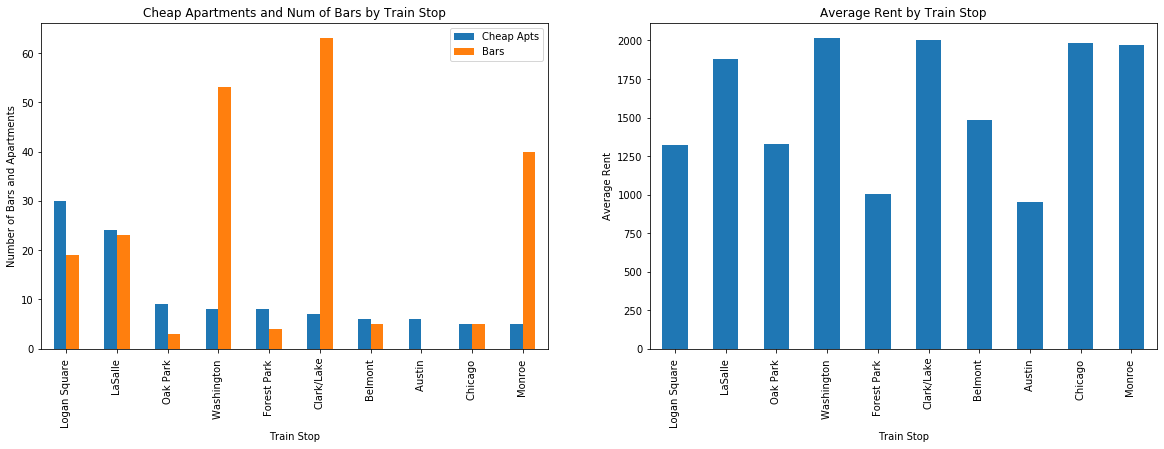

In [43]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Bar Chart
top_stops[['Cheap Apts', 'Bars']].plot(kind='bar', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Cheap Apartments and Num of Bars by Train Stop')
ax0.set_xlabel('Train Stop')
ax0.set_ylabel('Number of Bars and Apartments')



# Subplot 1: Bar Chart
top_stops['Avg Rent'].plot(kind='bar', figsize=(20, 6), ax=ax1) # add to subplot 1
ax1.set_title('Average Rent by Train Stop')
ax1.set_xlabel('Train Stop')
ax1.set_ylabel('Average Rent')

plt.show()

### As we can see from the graphs, there are many train stops with lots of bars (notably downtown). However, if your rent is too high, you will not have any money to drink with.

Lets take a look at the top two train stops with the most cheap apartments and bars: Logan Square and LaSalle

In [44]:
logan = nearby_apts[nearby_apts['Nearby Stations'].str.contains('Logan Square')]
lasalle = nearby_apts[nearby_apts['Nearby Stations'].str.contains('LaSalle')]

In [45]:
logan_pr = logan[['price']]
lasalle_pr = lasalle[['price']]

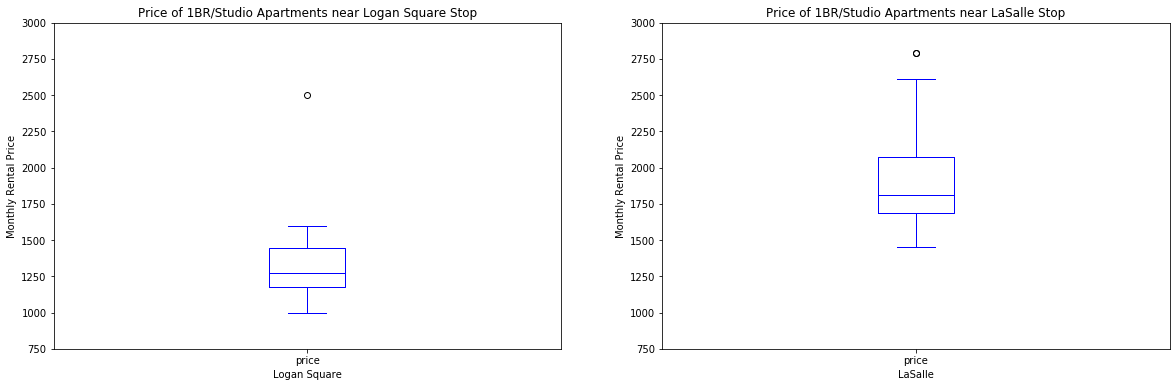

In [46]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
logan_pr['price'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Price of 1BR/Studio Apartments near Logan Square Stop')
ax0.set_xlabel('Logan Square')
ax0.set_ylabel('Monthly Rental Price')
ax0.set_ylim([750,3000])

# Subplot 2: Box plot
lasalle_pr['price'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title('Price of 1BR/Studio Apartments near LaSalle Stop')
ax1.set_xlabel('LaSalle')
ax1.set_ylabel('Monthly Rental Price')
ax1.set_ylim([750,3000])

plt.show()

Although the two train stops (Logan Square and LaSalle) have similar number of "cheap" apartments (30 and 24, respectively)
the price of apartments within 600m of the train varies a lot as you can see from the above box plots.

Logan Square has a much cheaper apartments, on the whole. This fact is likely to correlate with the price of drinks in the vincinity.
If an area has expensive apartments, the bars are likely to be expensive as well. If our apartment-seeker is looking for inexpensive bars, Logan Square
is a better choice.

## Maps of the top 2 neighborhoods

In [47]:
logan_cheap = logan.loc[logan['Rent'] == 'low']
logan_med = logan.loc[logan['Rent'] == 'med']
logan_lux = logan.loc[logan['Rent'] == 'high']

lasalle_cheap = lasalle.loc[lasalle['Rent'] == 'low']
lasalle_med = lasalle.loc[lasalle['Rent'] == 'med']
lasalle_lux = lasalle.loc[lasalle['Rent'] == 'high']

In [48]:
logan_bars = get_area_bars (stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude, 600)
lasalle_bars = get_area_bars (stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude, 600)

In [49]:
lasalle_bars.head()

,name,categories,latitude,longitude,isBar
0,First Draft,Sports Bar,41.873259,-87.630563,True
1,Kasey's Tavern,Pub,41.873317,-87.629284,True
3,The Marq,Bar,41.879010,-87.629732,True
4,Sky-Ride Cocktail Lounge,Dive Bar,41.876851,-87.630879,True
7,Brando's Speakeasy,Speakeasy,41.877175,-87.629143,True


In [50]:
# create map of Near Logan Square using latitude and longitude values
map_logan = folium.Map(location=[stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude], zoom_start=16)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_logan)
                                 
# Add a red circle around Logan Square Stop
folium.Circle([stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude], radius=600, color='red', fill=False).add_to(map_logan)

# add cheap apartment markers to map
for lat, lng, price in zip(logan_cheap['latitude'], logan_cheap['longitude'], ('$' + logan_cheap['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_logan)  

# add med apartment markers to map
for lat, lng, price in zip(logan_med['latitude'], logan_med['longitude'], ('$' + logan_med['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=1,
        parse_html=False).add_to(map_logan)  
                                 
                                 
# add bar markers to map
for lat, lng, name in zip(logan_bars['latitude'], logan_bars['longitude'], logan_bars['name']):
    label = name
    label = folium.Popup(label, parse_html=True)   
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='glass')
    ).add_to(map_logan)
map_logan

In [51]:
# create map of Near lasalle Square using latitude and longitude values
map_lasalle = folium.Map(location=[stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude], zoom_start=16)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lasalle)
                                 
# Add a red circle around lasalle Square Stop
folium.Circle([stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude], radius=600, color='red', fill=False).add_to(map_lasalle)

# add cheap apartment markers to map
for lat, lng, price in zip(lasalle_cheap['latitude'], lasalle_cheap['longitude'], ('$' + lasalle_cheap['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)  

# add med apartment markers to map
for lat, lng, price in zip(lasalle_med['latitude'], lasalle_med['longitude'], ('$' + lasalle_med['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)  
    
# add lux apartment markers to map
for lat, lng, price in zip(lasalle_lux['latitude'], lasalle_lux['longitude'], ('$' + lasalle_lux['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)                                   
                                 
# add bar markers to map
for lat, lng, name in zip(lasalle_bars['latitude'], lasalle_bars['longitude'], lasalle_bars['name']):
    label = name
    label = folium.Popup(label, parse_html=True)   
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='glass')
    ).add_to(map_lasalle)
map_lasalle

## Results and Discussion<a name="results"></a>

The results of this analysis is that for a young, price conscious apartment seeker, Logan Square is the train stop that they should search for an apartment near. There are the highest number of cheap one bedroom and studio apartments and has many bars within walking distance. While it's true that one person only needs one apartment, with many cheap apartments to choose from, one is more likely to find one that is acceptable. In addition, it can sometimes be difficult to let an apartment, even if it is available. Landlords and building managers have many applicants to choose from and can be choosy (or discriminatory).

In my analysis, Logan Square was compared to the second highest ranked train stop, LaSalle. While the LaSalle stop had more bars, and almost as many cheap apartments available, the average rent in the area was significantly higher than Logan Square, and thus was rated a more expensive area.

Due to the fact that our apartment data was limited to one bedroom and studio apartments, some areas were over-represented due to common architectural designs in the neighborhoods. Logan Square, the train stop recommended by this analysis, is located in a neighborhood that has many courtyard buildings all comprised of one bedroom or studio apartments. Nearby train stops (California, for instance) most likely have many cheap apartments, but in that neighborhood 2 and 3 bedroom apartments are more common.

Another way that our data could be limited is that our source of apartment listings (Craigslist) is an online listing platform favored by middle-to-high rent apartments. In some neighborhoods, it is much more common to have a physical sign in the window and the owner's phone number to call for more information. Additionally, some high end apartments are only let through their own website portals or agents, and are not listed on Craigslist.

This project could easily be adapted to find a train stop or apartment for other scenarios or requirements. For instance - if our apartment seeker wished to move in with a roommate or partner, they could look for a two bedroom apartment instead and this would change the results significantly. In addition, one might be more comfortable taking the bus or walking further and could increase the radius from 600 meters. If someone was looking for a quieter living situation, they could look for apartments near parks, or libraries, or even away from bars. There are many possibilities with only a few changes.

## Conclusion<a name="conclusion"></a>

Through the analysis of Craigslist apartment listings and bars found through the Foursquare API, one train stop was clearly had the most cheap apartments and many bars - Logan Square. If our apartment seeker was looking, this area would be a clear choice to start looking. The results were not completely unexpected for me, as I know the area well, but I was surprised at how expensive other areas have become in the last few years.

This project was a lot of fun and very enlightening for me, I got a lot of practice using python and pandas. I also learned new skills such as web scraping and using the Foursquare API.